# Bayesian computations with Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS can easily compute the evidence and posterior of a neural network. The larger number of parameters means that we should be careful with how accurate we want this to be. With high precision, we'll need more likelihood evaluations

## Overview

In this tutorial we'll cover:
1. How to build a JAXNS model of a neural network using [Haiku](https://github.com/deepmind/dm-haiku)
2. How to do posterior and evidence estimation with JAXNS

In [1]:
try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")

from jax import numpy as jnp, random, vmap
import jax
from jax.flatten_util import ravel_pytree

from jaxns import PriorChain, UniformPrior
from jaxns import NestedSampler, resample
from jaxns import plot_diagnostics
from jax.scipy.optimize import minimize
from itertools import product

import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"

from jax.config import config

config.update("jax_enable_x64", True)



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 7
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))#N,2
y = vmap(xor_reduce)(x)[:, None]#N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x,y):
    print(f"{input} -> {output}")


INFO[2022-04-09 00:50:54,752]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-04-09 00:50:54,753]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-04-09 00:50:54,753]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-04-09 00:50:54,754]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Data:
[1. 1. 1. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0.] -> [False]
[1. 1. 1. 0. 0. 1. 1.] -> [ True]
[1. 1. 1. 0. 0. 1. 0.] -> [False]
[1. 1. 1. 0. 0. 0. 1.] -> [False]
[1. 1. 1. 0. 0. 0. 0.] -> [ True]
[1. 1. 0. 1. 1. 1. 1.] -> [False]
[1. 1. 0. 1. 1. 1. 0.] -> [ True]
[1. 1. 0. 1. 1. 0. 1.] -> [ True]
[1. 1. 0. 1. 1. 0. 0.] -> [False]
[1. 1. 0. 1. 0. 1. 1.] -> [ True]
[1. 1. 0. 1. 0. 1. 0.] -> [False]
[1. 1. 0. 1. 0. 0. 1.] -> [False]
[1. 1. 0. 1. 0. 0. 0.] -> [ True]
[1. 1. 0. 0. 1. 1. 1.] -> [ True]
[1. 1. 0. 0. 1. 1. 0.] -> [False]
[1. 1. 0. 0. 1. 0. 1.] -> [False]
[1. 1. 0. 0. 1. 0. 0.] -> [ True]
[1. 1. 0. 0. 0. 1. 1.] -> [False]
[1. 1. 0

In [3]:
# Define the likelihood, using Haiku as our framework for neural networks

def model(x, is_training=False):
    mlp = hk.Sequential([hk.Linear(4),
                         jax.nn.sigmoid,
                         hk.Linear(1)])
    return mlp(x)

model = hk.without_apply_rng(hk.transform(model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)

def softplus(x):
    return jnp.log1p(jnp.exp(x))

def log_likelihood(params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, jnp.float64)


Number of parameters: 37


In [4]:

# Build the model

with PriorChain() as prior_chain:
    # we'll effectively place no prior on the parameters, other than requiring them to be within [-10,10]
    UniformPrior('params', -10*jnp.ones(n_dims), 10.*jnp.ones(n_dims))

# We'll do some strange things here.
# num_slices -> low: We'll make the sampler do very few slices. This will lead to large correlation between samples, and poor estimate of the evidence.
# This is alright, because we'll be looking for the maximum likelihood solution.
ns = NestedSampler(loglikelihood=log_likelihood, prior_chain=prior_chain,
                   num_parallel_samplers=6, dynamic=True,
                  sampler_kwargs=dict(min_num_slices=prior_chain.U_ndims*5))


WARNING[2022-04-09 00:50:56,390]: Increasing max_samples (100000) by 3600 to evenly divide samples_per_step


In [5]:
# Let's test the model with a small sanity check.
prior_chain.test_prior(random.PRNGKey(42), 10, log_likelihood)

INFO[2022-04-09 00:50:57,316]: Log-likelihood: -1.425439012846308
INFO[2022-04-09 00:50:57,325]: Log-likelihood: -2.007583475962746
INFO[2022-04-09 00:50:57,332]: Log-likelihood: -3.411012203506694
INFO[2022-04-09 00:50:57,340]: Log-likelihood: -4.778398399659211
INFO[2022-04-09 00:50:57,348]: Log-likelihood: -2.6045031959068297
INFO[2022-04-09 00:50:57,356]: Log-likelihood: -2.577393803747621
INFO[2022-04-09 00:50:57,364]: Log-likelihood: -1.6884011576143083
INFO[2022-04-09 00:50:57,372]: Log-likelihood: -1.5899965012685466
INFO[2022-04-09 00:50:57,381]: Log-likelihood: -2.0759869409314455
INFO[2022-04-09 00:50:57,390]: Log-likelihood: -6.011793538638495


In [6]:
results = ns(random.PRNGKey(42), num_live_points=prior_chain.U_ndims*10, 
             termination_live_evidence_frac=1e-5, G=0., termination_ess=1e5)

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/dispatch.py:232: UserWarning: The jitted function while includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


--------
Termination Conditions:
Reached max samples
Used max num steps
--------
# likelihood evals: 34771621
# samples: 103600
# likelihood evals / sample: 335.6
--------
logZ=-2.6257 +- 0.01
H=0.18
ESS=39210
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: -1.6 +- 5.6 | -8.6 / -2.4 / 6.8 | -7.8 | -0.9
params[1]: 1.5 +- 5.6 | -7.0 / 2.2 / 8.6 | 7.4 | 3.5
params[2]: 1.2 +- 5.7 | -7.3 / 1.8 / 8.5 | -4.1 | 3.7
params[3]: -0.6 +- 5.7 | -8.3 / -1.0 / 7.6 | 9.9 | -2.7
params[4]: -1.7 +- 5.6 | -8.6 / -2.5 / 6.8 | -2.5 | -9.3
params[5]: 1.5 +- 5.6 | -6.9 / 2.2 / 8.6 | -5.6 | 8.4
params[6]: -0.4 +- 5.7 | -8.1 / -0.7 / 7.7 | -6.9 | -3.8
params[7]: 0.5 +- 5.8 | -7.7 / 0.9 / 8.3 | -8.9 | 6.6
params[8]: -1.2 +- 5.6 | -8.4 / -1.7 / 7.2 | 1.5 | -4.2
params[9]: 1.0 +- 5.7 | -7.4 / 1.6 / 8.4 | -4.8 | 7.1
params[10]: 0.9 +- 5.7 | -7.5 / 1.4 / 8.4 | -4.2 | 7.7
params[11]: 1.6 +- 5.6 | -6.9 / 2.4 / 8.6 | 5.6 | 7.7
params[12]: 0.3 +- 5.7 | -7.9 / 0.4 / 8.

WARNING[2022-04-09 00:53:09,374]: No handles with labels found to put in legend.
WARNING[2022-04-09 00:53:09,933]: No handles with labels found to put in legend.


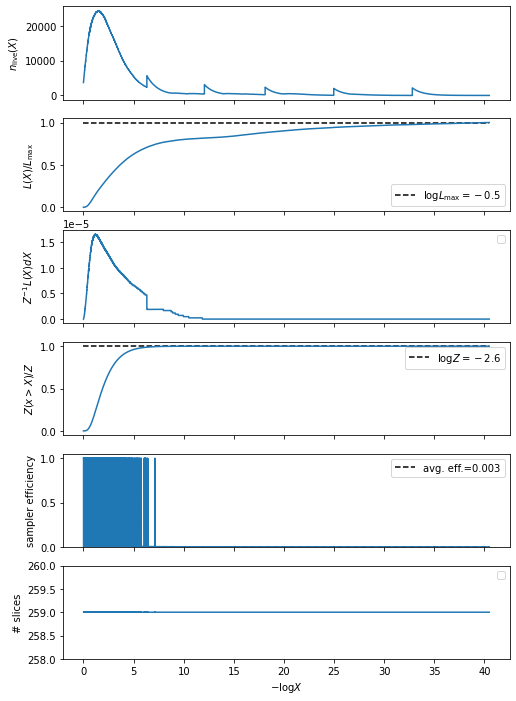

In [7]:
ns.summary(results)
plot_diagnostics(results)

In [21]:
samples = resample(random.PRNGKey(45), results.samples, results.log_dp_mean, S=int(results.ESS), replace=True)

def predict(params):
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:,0]

predictions = vmap(predict)(samples['params'])

for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {jnp.percentile(predictions[:,i],jnp.asarray([5,50,95]))}")

0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [9.56036493e-04 4.97034828e-01 9.99140105e-01]
1: [1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: [7.87415987e-04 4.96115537e-01 9.99336480e-01]
2: [1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: [7.59896747e-04 4.98238002e-01 9.99316075e-01]
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [6.49339060e-04 5.00440700e-01 9.99471122e-01]
4: [1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: [7.91699814e-04 5.05736237e-01 9.99341463e-01]
5: [1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: [6.02931972e-04 5.21017965e-01 9.99523622e-01]
6: [1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: [6.23834595e-04 5.13169674e-01 9.99477440e-01]
7: [1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: [4.85352157e-04 5.06185027e-01 9.99605339e-01]
8: [1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: [7.45796161e-04 5.00166396e-01 9.99303909e-01]
9: [1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: [6.02557523e-04 5.14939678e-01 9.99470830e-01]
10: [1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: [6.03816371e-04 5.05888591e-01 9.9

98: [0. 0. 1. 1. 1. 0. 1.] -> [False] | pred: [4.88446808e-04 5.08663833e-01 9.99589001e-01]
99: [0. 0. 1. 1. 1. 0. 0.] -> [ True] | pred: [3.80416402e-04 5.12077504e-01 9.99652378e-01]
100: [0. 0. 1. 1. 0. 1. 1.] -> [False] | pred: [4.31573178e-04 5.04537963e-01 9.99621744e-01]
101: [0. 0. 1. 1. 0. 1. 0.] -> [ True] | pred: [3.43225002e-04 5.14545219e-01 9.99696386e-01]
102: [0. 0. 1. 1. 0. 0. 1.] -> [ True] | pred: [4.11977591e-04 5.26629548e-01 9.99688001e-01]
103: [0. 0. 1. 1. 0. 0. 0.] -> [False] | pred: [3.14970181e-04 5.06119085e-01 9.99747201e-01]
104: [0. 0. 1. 0. 1. 1. 1.] -> [False] | pred: [4.05625267e-04 4.94958412e-01 9.99590079e-01]
105: [0. 0. 1. 0. 1. 1. 0.] -> [ True] | pred: [3.38241214e-04 5.08593901e-01 9.99697796e-01]
106: [0. 0. 1. 0. 1. 0. 1.] -> [ True] | pred: [3.65734663e-04 5.10207455e-01 9.99690462e-01]
107: [0. 0. 1. 0. 1. 0. 0.] -> [False] | pred: [2.85326194e-04 4.93830775e-01 9.99714950e-01]
108: [0. 0. 1. 0. 0. 1. 1.] -> [ True] | pred: [3.54948625e-04

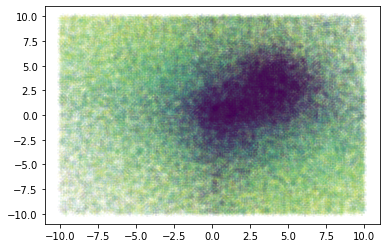

In [45]:
import pylab as plt
plt.scatter(*results.samples['params'][:,-5:-3].T, marker='+',alpha=0.05, c=jnp.exp(results.log_dp_mean))
plt.show()

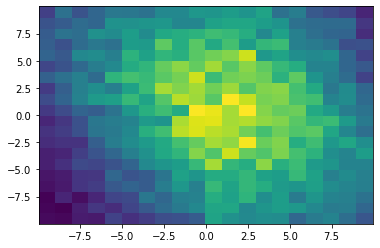

In [44]:
plt.hist2d(*samples['params'][:,-5:-3].T, bins=20)
plt.show()